## Important Libraries

In [46]:
import numpy as np
import seaborn as sns 
import os
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,Input,Conv2D,MaxPooling2D
from keras.applications.vgg19 import VGG19
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Initial Hyperparameters

In [47]:
img_size=(224,224)
batch_size=64
seed=42
epochs=30

## Reading Training Data from Training Images Path

In [48]:
train_generator=ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

In [49]:
train_dir=r'/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
train_data=train_generator.flow_from_directory(directory=train_dir,
                                              subset='training',
                                              class_mode='categorical',
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              target_size=img_size, 
                                              seed=seed )

Found 60000 images belonging to 5 classes.


## Splitting Dataset to Training and Validation Data

In [50]:
val_data=train_generator.flow_from_directory(directory=train_dir,
                                            subset='validation',
                                            class_mode='categorical',
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            target_size=img_size)

Found 15000 images belonging to 5 classes.


## Showing Training Images

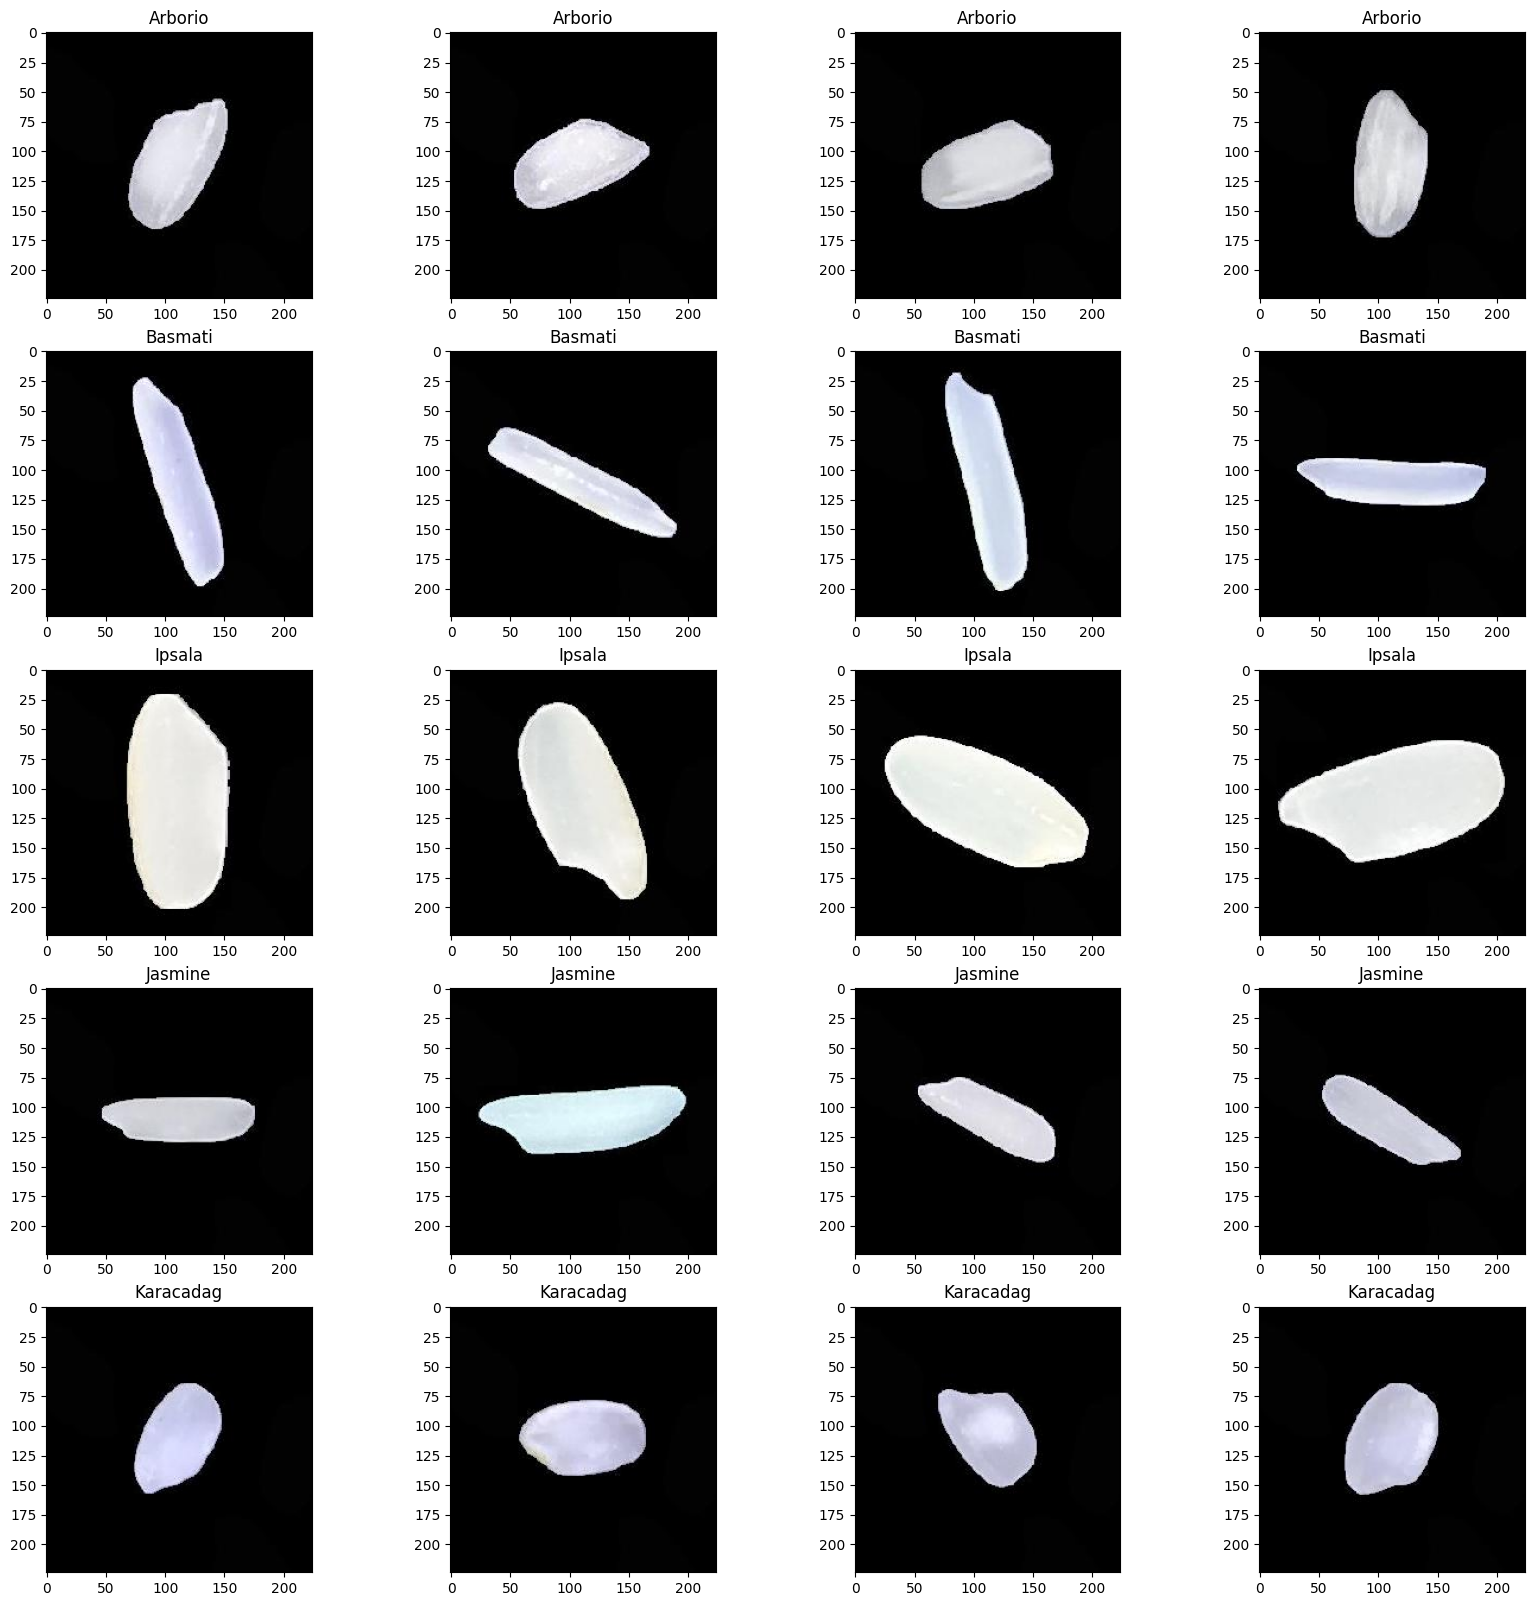

In [51]:
plt.figure(figsize=(20,20))
plot_index=1
for category in train_data.class_indices.keys():
    path=os.path.join(train_dir,category)
    img_num=1
    for img in os.listdir(path):
        if img_num<=4:
            img_path=os.path.join(path,img)
            image=load_img(img_path,target_size=img_size)
            plt.subplot(5,4,plot_index)
            plt.title(category.capitalize())
            plt.imshow(image)
            img_num+=1
            plot_index+=1
        else:
            break
plt.show()            

## Creating Model 

In [52]:
vgg19_model=VGG19(input_shape=(224,224,3))
len(vgg19_model.layers)

26

In [53]:
vgg19_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 143,667,240 (548.05 MB)

 Trainable params: 143,667,240 (548.05 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model=Sequential()
for layer in vgg19_model.layers[:-1]:
    model.add(layer)

In [55]:
for layer in model.layers:
    layer.trainable=False

In [56]:
model.add(Dense(5,activation='softmax'))

In [57]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 139,590,725 (532.50 MB)

 Trainable params: 20,485 (80.02 KB)

 Non-trainable params: 139,570,240 (532.42 MB)

In [58]:
cp=ModelCheckpoint('rice_image_weights.keras',
                    monitor='val_loss',
                    save_best_only=True,
                    verbose=1)
early_stopping=EarlyStopping(monitor='val_loss',
                             patience=5,
                             min_delta=0.001,
                             restore_best_weights=True,
                             verbose=1)
reduceLR=ReduceLROnPlateau(monitor='val_loss',
                           patience=5,
                           min_delta=0.001,
                           factor=0.5,
                           verbose=1)
callbacks=[cp,early_stopping,reduceLR]

In [59]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

## Training Model

In [60]:
history=model.fit(train_data,validation_data=val_data,epochs=epochs,steps_per_epoch=train_data.samples//train_data.batch_size,callbacks=callbacks)

Epoch 1/30
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7658 - loss: 0.7344
Epoch 1: val_loss improved from inf to 0.26255, saving model to rice_image_weights.keras
937/937 ━━━━━━━━━━━━━━━━━━━━ 500s 508ms/step - accuracy: 0.7659 - loss: 0.7341 - val_accuracy: 0.9160 - val_loss: 0.2625 - learning_rate: 0.0010
Epoch 2/30
  1/937 ━━━━━━━━━━━━━━━━━━━━ 5:06 328ms/step - accuracy: 0.8906 - loss: 0.3010
Epoch 2: val_loss improved from 0.26255 to 0.26183, saving model to rice_image_weights.keras
937/937 ━━━━━━━━━━━━━━━━━━━━ 77s 81ms/step - accuracy: 0.8906 - loss: 0.3010 - val_accuracy: 0.9187 - val_loss: 0.2618 - learning_rate: 0.0010
Epoch 3/30
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9383 - loss: 0.2175
Epoch 3: val_loss improved from 0.26183 to 0.19307, saving model to rice_image_weights.keras
937/937 ━━━━━━━━━━━━━━━━━━━━ 373s 397ms/step - accuracy: 0.9383 - loss: 0.2174 - val_accuracy: 0.9418 - val_loss: 0.1931 - learning_rate: 0.0010
Epoch 4/30
  1/937 ━━━━━━━

## Evaluation

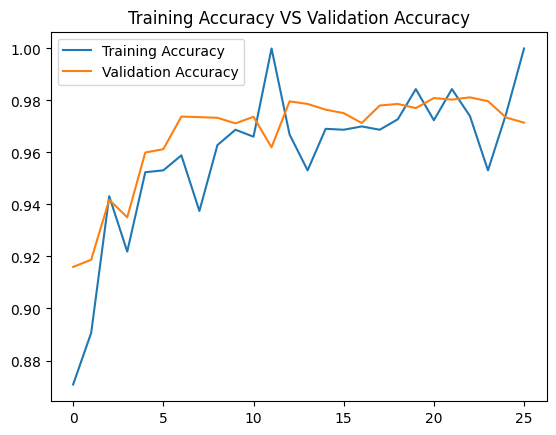

In [61]:
plt.title('Training Accuracy VS Validation Accuracy')
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.show()

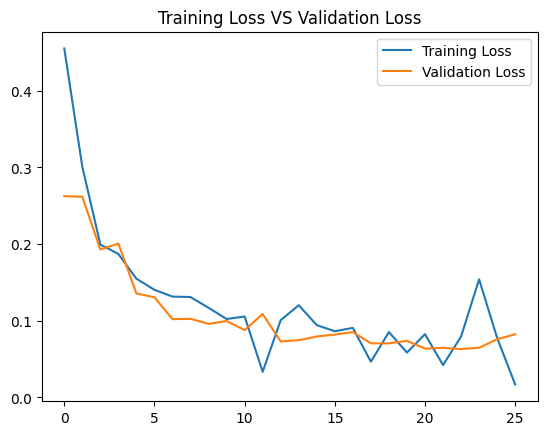

In [62]:
plt.title('Training Loss VS Validation Loss')
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

In [63]:
model.evaluate(val_data)

235/235 ━━━━━━━━━━━━━━━━━━━━ 74s 315ms/step - accuracy: 0.9742 - loss: 0.0836


[0.0636766105890274, 0.9809333086013794]

In [64]:
y_pred=model.predict(val_data)
y_pred[0]

235/235 ━━━━━━━━━━━━━━━━━━━━ 72s 306ms/step


array([9.9941939e-01, 5.1274842e-09, 3.8683957e-05, 4.0554491e-04,
       1.3630615e-04], dtype=float32)

In [65]:
y_prediction=np.argmax(y_pred,axis=1)
y_prediction[0]

0

In [66]:
report=classification_report(val_data.classes,y_prediction)
print("Classification Report : \n"+report)

Classification Report : 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3000
           1       0.98      0.97      0.98      3000
           2       1.00      0.99      1.00      3000
           3       0.95      0.98      0.97      3000
           4       0.98      0.99      0.99      3000

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



In [67]:
conf_mat=confusion_matrix(val_data.classes,y_prediction)
conf_mat

array([[2906,    0,    0,   41,   53],
       [   0, 2917,    0,   83,    0],
       [   1,    0, 2983,   16,    0],
       [   2,   55,    4, 2937,    2],
       [  29,    0,    0,    0, 2971]])

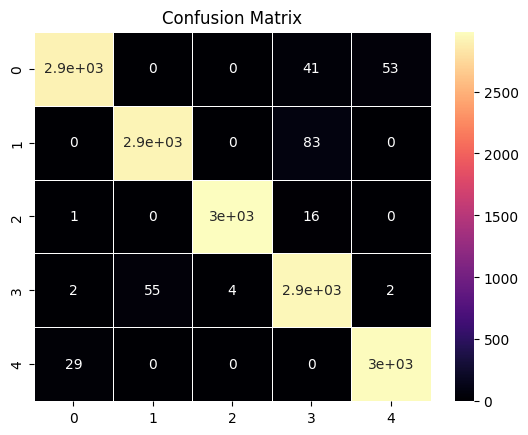

In [68]:
plt.title('Confusion Matrix')
sns.heatmap(conf_mat,annot=True,cmap='magma',linecolor='white',linewidths=0.5)
plt.show()

## Saving Model

In [69]:
model.save('rice_image_model.h5')

## Loading Model

In [70]:
model=load_model('rice_image_model.h5')